## Testing notebook

Testing trained models.

Making some basic API for them.

Tuning models.

In [30]:
%matplotlib inline
%env JOBLIB_TEMP_FOLDER=/tmp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

import nltk
from nltk.corpus import stopwords
from os.path import join
from glob import glob

from time import time
from scipy.sparse import csr_matrix, lil_matrix

env: JOBLIB_TEMP_FOLDER=/tmp


In [2]:
with open('../Data/test_names.pkl', 'rb') as f:
    names = pickle.load(f)

count_vect = joblib.load('../Data/models/countVect.pkl')
dataset = count_vect.transform(names)

lda = joblib.load('../Data/models/lda.pkl')

In [3]:
#Let\`s do simple interface class
class TopicModeler(object):
    '''
    Inteface object for CountVectorizer + LDA simple
    usage.
    '''
    def __init__(self, count_vect, lda):
        '''
        Args:
             count_vect - CountVectorizer object from sklearn.
             lda - LDA object from sklearn.
        '''
        self.lda = lda
        self.count_vect = count_vect
        self.count_vect.input = 'content'
        
    def __call__(self, text):
        '''
        Gives topics distribution for a given text
        Args:
             text - raw text via python string.
        returns: numpy array - topics distribution for a given text.
        '''
        vectorized = self.count_vect.transform([text])
        lda_topics = self.lda.transform(vectorized)
        return lda_topics
    def get_keywords(self, text, n_topics=3, n_keywords=5):
        '''
        For a given text gives n top keywords for each of m top texts topics.
        Args:
             text - raw text via python string.
             n_topics - int how many top topics to use.
             n_keywords - how many top words of each topic to return.
        returns:
                list - of m*n keywords for a given text.
        '''
        lda_topics = self(text)
        lda_topics = np.squeeze(lda_topics, axis=0)
        n_topics_indices = lda_topics.argsort()[-n_topics:][::-1]
        
        top_topics_words_dists = []
        for i in n_topics_indices:
            top_topics_words_dists.append(self.lda.components_[i])
        
        keywords = np.zeros(shape=(n_keywords*n_topics, self.lda.components_.shape[1]))
        for i,topic in enumerate(top_topics_words_dists):
            n_keywords_indices = topic.argsort()[-n_keywords:][::-1]
            for k,j in enumerate(n_keywords_indices):
                keywords[i * n_keywords + k, j] = 1
        keywords = self.count_vect.inverse_transform(keywords)
        keywords = [keyword[0] for keyword in keywords]
        return keywords  

In [4]:
#Picking some text from dataset
ind = 18
with open(names[ind],'r') as f:
    text = f.read()
print(len(text))
print(names[ind])

35399
../Data/raw_data/Агентство путешествий "Краски Мира".txt


In [5]:
#initialiazing interface object
tm = TopicModeler(count_vect, lda)

In [6]:
#Let`s what words it will give us for the choosen text.
key_words = tm.get_keywords(text, n_topics=1, n_keywords=10)
print(key_words)

['photo', 'social', 'travel', 'сообщество', 'путешествие', 'евро', 'проживание', 'цена', 'польша', 'вылет']


In [7]:
#the text itself
text

'Эксклюзив!! Насыщенный 8-дневный тур по Италии и Швейцарии. Туристов ждет знакомство с главными городами севера Италии – романтичной Вероной, модным Миланом, живописным Турином, а также посещение двух самых крупных городов Швейцарии – Берна и Цюриха. Все переезды осуществляются на комфортабельном автобусе в сопровождении русскоговорящего гида. Разыграли вкусные призы среди посетителей нашего стенда на Дне Франции во FLACON.\nПоздравляем победителей:\n№ 25 Кочеров Александр\n№ 27 Иконникова Виола\n№ 54 Рыбаков Саша\n№ 82 Новиков Андрей\n№ 94 Чиркова Дарья\n№ 114 Власенко Евгения\n№ 124 Скаредина Татьяна\n№ 135 Шимитова Альбина Алмазовна\n№ 138 Малых Юлия Сергеевна\n№ 153 Глазова Елена Викторовна\n№ 177 Веремьева Зоя\n№187 Кириленко Михаил Владимирович\n№ 197 Таниева Луиза\n№ 207 Румянцева Наталия\n№ 225 Петренко Оксана\nПакеты с призами ждут Вас в нашем офисе на Арбатской (Нижний Кисловский пер., д.3, оф.29 ) Amirandes | Greece forever Grecotel Греция в стиле Grecotel Grecotel Corfu Im

### It seems to be good to extend  stopwords list.
#### And better to do it somehow automatically.
#### Let\`s try to do it the following way:
1. For each topic picking top n(n=5) top words.
3. Computing idf or tf_idf for those picked words on train corpus.
4. Adding to stopwords most common of those words(for example 10% with smallest idf).

In [9]:
#getting n_top words indices for every topic
sorted_words_coeffs = lda.components_.argsort(axis=1)
n_top = 10
top_coefs = sorted_words_coeffs[:,-n_top:][:,::-1]

#making those texts consisting of top words
vect_texts = np.zeros((top_coefs.shape[0], lda.components_.shape[1]),
                       )
for i,n_top_coefs in enumerate(top_coefs):
    for coef in n_top_coefs:
        vect_texts[i,coef] = 1


In [10]:
#transforming them to term-doc vectors.
top_words = count_vect.inverse_transform(vect_texts)
top_words_set = set()
for words in top_words:
    top_words_set.update(set(words))
print(len(top_words_set))

527


In [13]:
#specifying words for TfidfVectorizer to fit on.
voc_to_idf = {word : i for i, word in enumerate(top_words_set)}

#loading stopwords from all the sources we got
#loading train/test split.
with open('../Data/stopwords/stopwords.pkl', 'rb') as f:
    stopwords = pickle.load(f)

with open('../Data/train_names.pkl', 'rb') as f:
    train_names = pickle.load(f)

In [15]:
#computing idfs
tfidf_tw = TfidfVectorizer(input='filename', vocabulary=voc_to_idf, stop_words=stopwords)
tfidf_tw.fit(train_names)

idfs = tfidf_tw.idf_
print(idfs.shape)

(527,)


## Let\`s see 10% top idf keywords

In [24]:
#computing n most common words
n_top = int(idfs.shape[0] * 0.05)

n_top_indices = np.argsort(idfs)[:n_top]

vect_words = np.zeros((n_top, len(idfs)))

In [25]:
#adding them to list.
inv_voc_to_idf = { voc_to_idf[key] : key for key in voc_to_idf.keys()}
extra_stop_words = []
for ind in n_top_indices:
    extra_stop_words.append(inv_voc_to_idf[ind])
print(len(extra_stop_words))

26


In [26]:
#let\`s see them.
print(extra_stop_words)

['любой', 'полностью', 'правильно', 'легко', 'следующий', 'интернет', 'небольшой', 'способ', 'сложно', 'настроение', 'столько', 'набор', 'вариант', 'название', 'речь', 'программа', 'конкурс', 'музыка', 'цель', 'фильм', 'цена', 'игра', 'система', 'играть', 'компания', 'приятно']


#### There are usually some informative words among choosen.
#### It may be a good idea to sort out only adjectives and adverbs.

In [ ]:
#In case we wanna add those picked words to stop words
stopwords = stopwords + extra_stop_words
#serializing all-merged stopwords set
with open('../Data/stopwords/stopwords_updated.pkl', 'wb') as f:
    pickle.dump(stopwords, f)

## Making texts embeddings

In [8]:
with open('../Data/test_names.pkl', 'rb') as f:
    names = pickle.load(f)

count_vect = joblib.load('../Data/models/countVect.pkl')
dataset = count_vect.transform(names)

lda = joblib.load('../Data/models/lda.pkl')

In [10]:
term_doc_matrix = count_vect.transform(names)
embeddings = lda.transform(term_doc_matrix)

In [72]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, AffinityPropagation, SpectralClustering, KMeans

In [89]:
kmeans = KMeans(n_clusters=30)
clust_labels = kmeans.fit_predict(embeddings)
clust_centers = kmeans.cluster_centers_

In [93]:
embeddings_to_tsne = np.concatenate((embeddings,clust_centers), axis=0)

tSNE =  TSNE(n_components=2, perplexity=15)
tsne_embeddings = tSNE.fit_transform(embeddings_to_tsne)
tsne_embeddings, centroids_embeddings = np.split(tsne_embeddings, [len(clust_labels)], axis=0)

In [94]:
print(tsne_embeddings.shape,centroids_embeddings.shape)

(416, 2) (30, 2)


In [95]:
clust_indices = np.unique(clust_labels)

clusters = {clust_ind : [] for clust_ind in clust_indices}
for emb, label in zip(tsne_embeddings, clust_labels):
    clusters[label].append(emb)

for key in clusters.keys():
    clusters[key] = np.array(clusters[key])
colors = cm.rainbow(np.linspace(0, 1, len(clust_indices)))

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


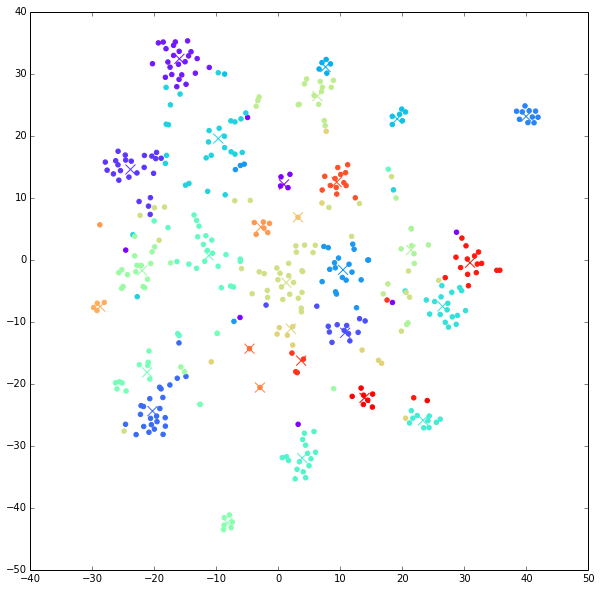

In [104]:
plt.figure(figsize=(10,10))
for ind, color in zip(clust_indices, colors):
    x = clusters[ind][:,0]
    y = clusters[ind][:,1]
    plt.scatter(x, y, color=color)
    
    centroid = centroids_embeddings[ind]
    plt.scatter(centroid[0],centroid[1], color=color, marker='x', s=100)

plt.show()